In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# cnn lstm model
from numpy import mean
from numpy import std
import seaborn as sns
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from sklearn.metrics import classification_report
from keras.layers import Permute, Reshape
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot
import numpy as np
import pandas as pd
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import StandardScaler

<ipython-input-3-cf6fbc8017d9>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
features=list()
with open('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/features.txt') as feat:
    features=[l.split()[1] for l in feat.readlines()]
print("Number of features = {}".format(len(features)))
for f in features:
    print(f,end=" | ")

Number of features = 561
tBodyAcc-mean()-X | tBodyAcc-mean()-Y | tBodyAcc-mean()-Z | tBodyAcc-std()-X | tBodyAcc-std()-Y | tBodyAcc-std()-Z | tBodyAcc-mad()-X | tBodyAcc-mad()-Y | tBodyAcc-mad()-Z | tBodyAcc-max()-X | tBodyAcc-max()-Y | tBodyAcc-max()-Z | tBodyAcc-min()-X | tBodyAcc-min()-Y | tBodyAcc-min()-Z | tBodyAcc-sma() | tBodyAcc-energy()-X | tBodyAcc-energy()-Y | tBodyAcc-energy()-Z | tBodyAcc-iqr()-X | tBodyAcc-iqr()-Y | tBodyAcc-iqr()-Z | tBodyAcc-entropy()-X | tBodyAcc-entropy()-Y | tBodyAcc-entropy()-Z | tBodyAcc-arCoeff()-X,1 | tBodyAcc-arCoeff()-X,2 | tBodyAcc-arCoeff()-X,3 | tBodyAcc-arCoeff()-X,4 | tBodyAcc-arCoeff()-Y,1 | tBodyAcc-arCoeff()-Y,2 | tBodyAcc-arCoeff()-Y,3 | tBodyAcc-arCoeff()-Y,4 | tBodyAcc-arCoeff()-Z,1 | tBodyAcc-arCoeff()-Z,2 | tBodyAcc-arCoeff()-Z,3 | tBodyAcc-arCoeff()-Z,4 | tBodyAcc-correlation()-X,Y | tBodyAcc-correlation()-X,Z | tBodyAcc-correlation()-Y,Z | tGravityAcc-mean()-X | tGravityAcc-mean()-Y | tGravityAcc-mean()-Z | tGravityAcc-std()-X | 

In [5]:
train = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None, encoding='latin-1')
train.columns = features
train['subject'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt', header=None, squeeze=True)
train['Activity'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
train['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
train.sample()

<ipython-input-5-143e3aaa4f62>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train['subject'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt', header=None, squeeze=True)
<ipython-input-5-143e3aaa4f62>:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train['Activity'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', names=['Activity'], squeeze=True)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
5759,0.292316,-0.016626,-0.10597,-0.986732,-0.993713,-0.98819,-0.987535,-0.992674,-0.988925,-0.925497,...,-0.095085,0.047727,0.071825,-0.752133,0.65219,-0.557689,-0.444559,26,6,LAYING


In [6]:
train.shape

(7352, 564)

In [7]:
test = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None, encoding='latin-1')
test.columns = features
test['subject'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt', header=None, squeeze=True)
test['Activity'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', names=['Activity'], squeeze=True)
test['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
test.sample()

<ipython-input-7-6086570604a6>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test['subject'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt', header=None, squeeze=True)
<ipython-input-7-6086570604a6>:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test['Activity'] = pd.read_csv('/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', names=['Activity'], squeeze=True)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
666,-0.41627,-0.024966,-0.03478,-0.297481,-0.642151,-0.602457,-0.314382,-0.68769,-0.608946,-0.746747,...,-0.074601,0.181606,-0.112195,0.264648,0.561643,-0.073342,-0.949228,9,6,WALKING_UPSTAIRS


In [8]:
test.shape

(2947, 564)

In [9]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


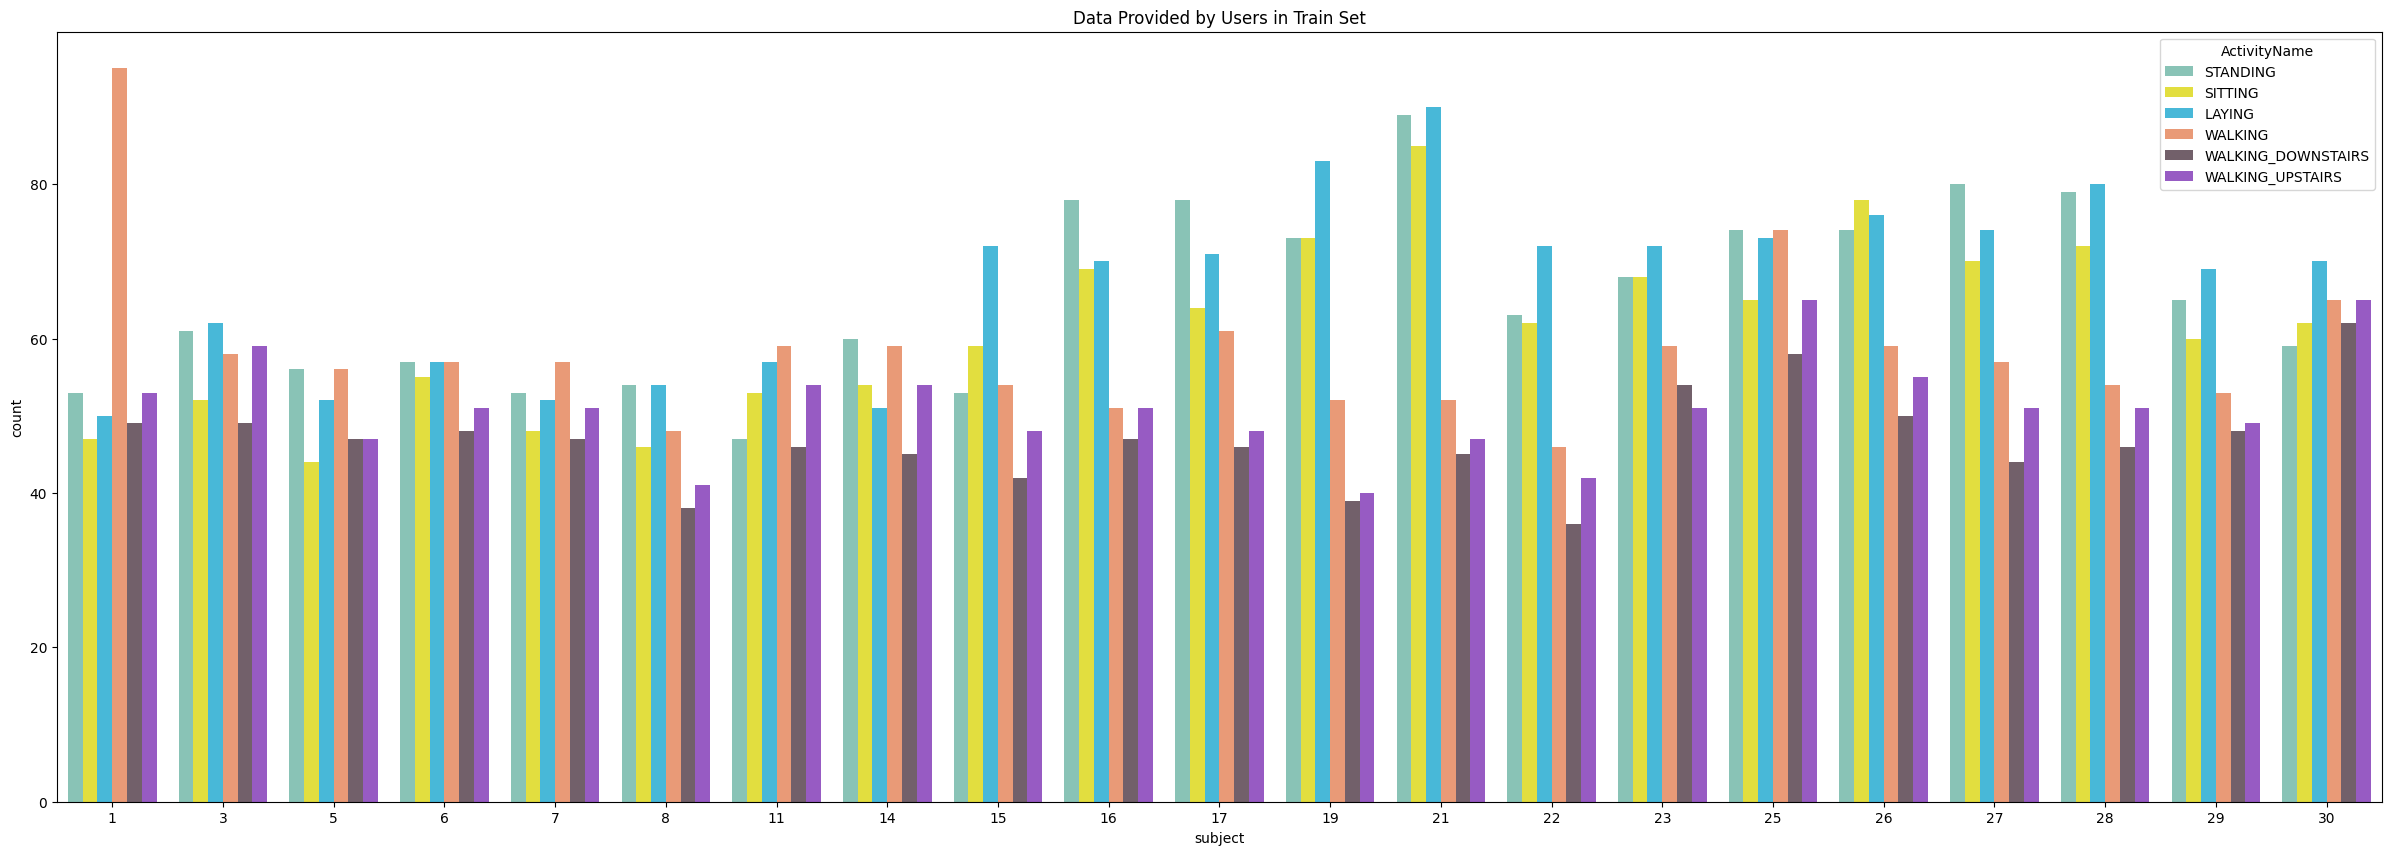

In [10]:
pyplot.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
pyplot.title('Data Provided by Users in Train Set')
pyplot.show()

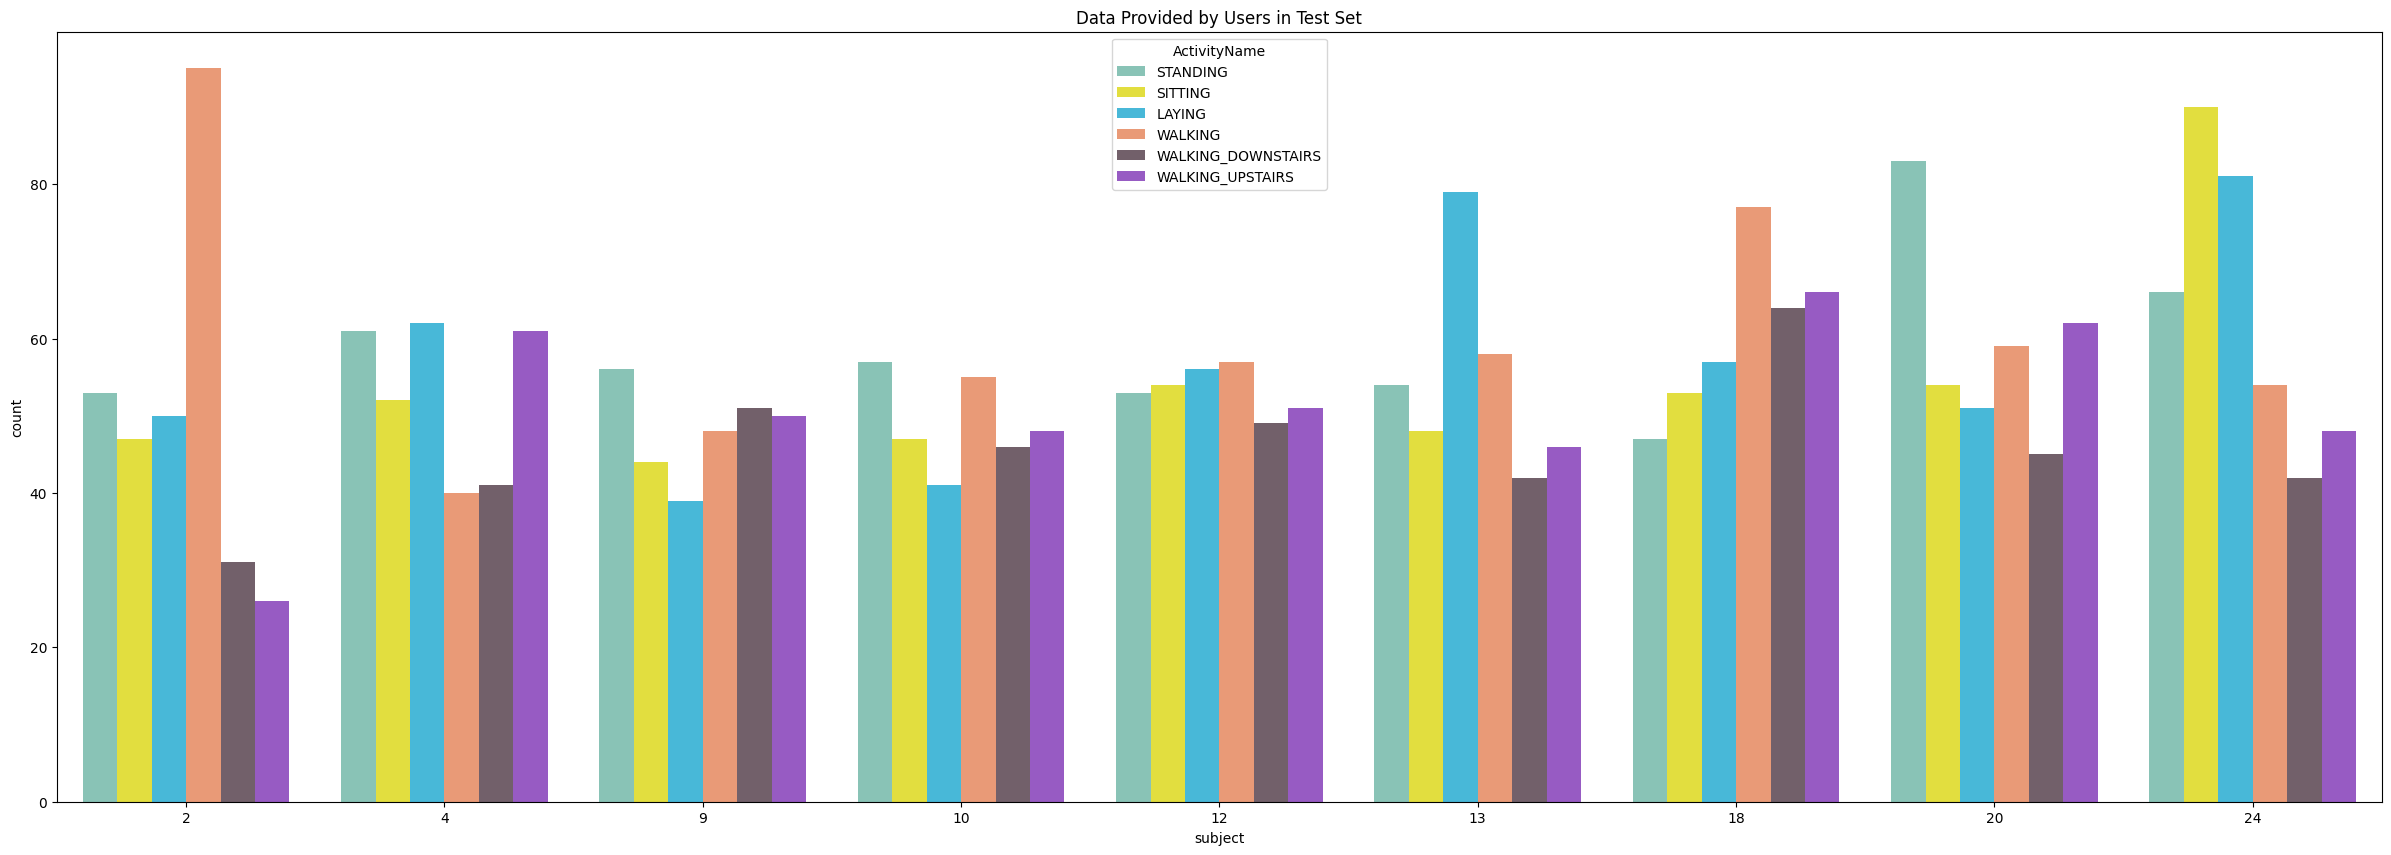

In [11]:
pyplot.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
pyplot.title('Data Provided by Users in Test Set')
pyplot.show()

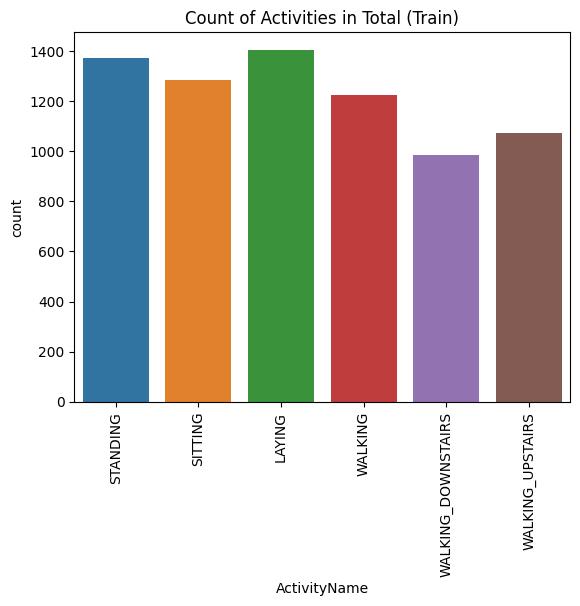

In [12]:
pyplot.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
pyplot.xticks(rotation=90)
pyplot.show()

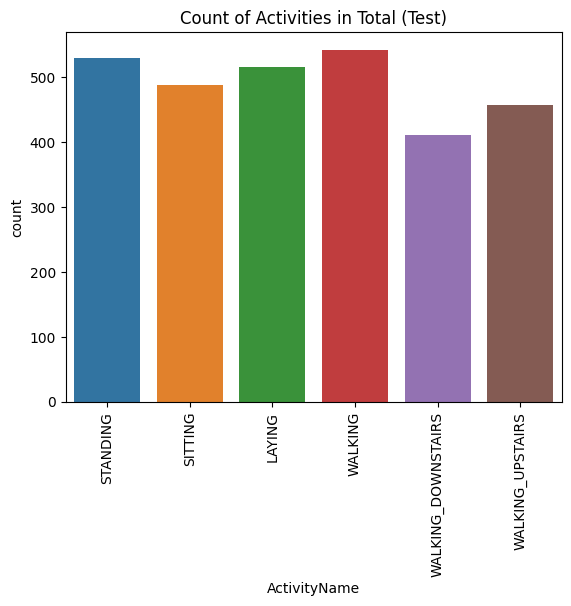

In [13]:
pyplot.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
pyplot.xticks(rotation=90)
pyplot.show()

In [14]:
def file_load(filepath):
    df = read_csv(filepath, header=None, delim_whitespace=True)
    return df.values    

In [15]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = dstack(datalist)
    return datalist

In [16]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [17]:

def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/content/drive/MyDrive/RBL/Dataset/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy
    

In [18]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 400, 150
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
n_steps = 4
n_length = 32
trainX = trainX.reshape(trainX.shape[0], n_length * n_steps, n_features)
testX = testX.reshape(testX.shape[0], n_length * n_steps, n_features)
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


In [19]:
# Data augmentation function
def augment_data(X, y):
    noise_factor = 0.05
    X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    X_augmented = np.concatenate((X, X_noisy), axis=0)
    y_augmented = np.concatenate((y, y), axis=0)
    return X_augmented, y_augmented

trainX, trainy = augment_data(trainX, trainy)

# Model definition with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu', input_shape=(128, n_features)))
    model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Conv1D(filters=hp.Int('filters_3', min_value=128, max_value=512, step=64), kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=hp.Int('filters_4', min_value=128, max_value=512, step=64), kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_1', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_2', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='output',
    project_name='HAR'
)

Accuracy = 94.94401216506958
93/93 [==============================] - 1s 7ms/step


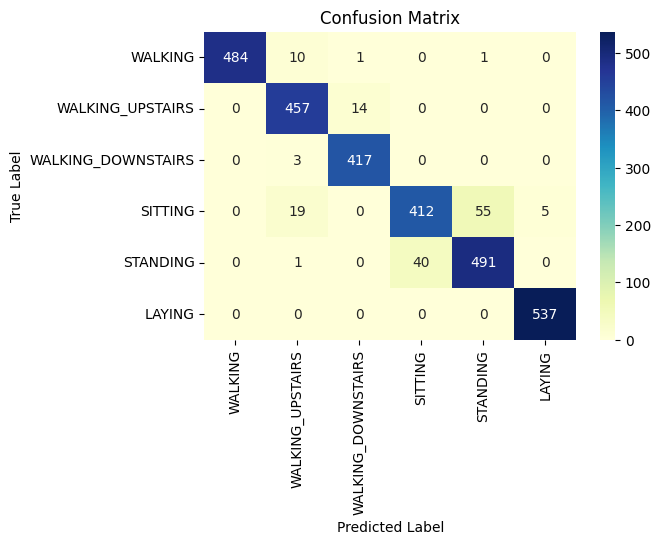

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       496
           1       0.93      0.97      0.95       471
           2       0.97      0.99      0.98       420
           3       0.91      0.84      0.87       491
           4       0.90      0.92      0.91       532
           5       0.99      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [20]:
# Search for the best hyperparameters
tuner.search(trainX, trainy, epochs=200, validation_data=(testX, testy), batch_size=128, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(testX, testy, batch_size=128, verbose=0)
score = accuracy * 100
print('Accuracy = {}'.format(score))

#classificationn report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

ypred_train = best_model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = best_model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

clr = metrics.classification_report(max_ytest, max_ypred_test)
print(clr)